# 🧠 Neural Network Model - Multi-class Classification

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.special import expit as sigmoid
import json

# Load Dataset

In [28]:
data = np.load("brain_mri_preprocessed.npz")

X_train, y_train = data["X_train"], data["y_train"]
X_test, y_test = data["X_test"], data["y_test"]

print("✅ Data successfully loaded!")
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Normalize (optional, since data is already in range 0–1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Data normalized: mean={X_train_scaled.mean():.3f}, std={X_train_scaled.std():.3f}")

✅ Data successfully loaded!
Train shape: (5521, 16384)
Test shape: (1205, 16384)
Data normalized: mean=-0.000, std=1.000


# ⚙️ Define Neural Network Architecture

In [14]:
input_layer_size  = X_train_scaled.shape[1]
hidden_layer_size = 64   # You can tune this
output_layer_size = 1    # Binary classification (Tumor vs No Tumor)

def sigmoid_gradient(z):
    """Derivative of the sigmoid function"""
    return sigmoid(z) * (1 - sigmoid(z))

def rand_initialize_weights(L_in, L_out):
    """Randomly initialize weights in [-ε, ε]"""
    epsilon_init = np.sqrt(6) / np.sqrt(L_in + L_out)
    return np.random.rand(L_out, L_in + 1) * 2 * epsilon_init - epsilon_init

# 🧮 Forward Propagation + Cost Function

In [15]:
def nn_cost_function(nn_params, input_size, hidden_size, output_size, X, y, Lambda):
    """Compute cost for a 2-layer neural network"""
    m = X.shape[0]

    # Reshape the flattened parameter vector into weight matrices
    Theta1 = nn_params[:hidden_size * (input_size + 1)].reshape(hidden_size, input_size + 1)
    Theta2 = nn_params[hidden_size * (input_size + 1):].reshape(output_size, hidden_size + 1)

    # Forward propagation
    X = np.c_[np.ones((m, 1)), X]
    z2 = X @ Theta1.T
    a2 = sigmoid(z2)
    a2 = np.c_[np.ones((m, 1)), a2]
    z3 = a2 @ Theta2.T
    a3 = sigmoid(z3)

    # Cost with regularization
    J = (-1 / m) * np.sum(y * np.log(a3) + (1 - y) * np.log(1 - a3))
    reg = (Lambda / (2 * m)) * (np.sum(np.square(Theta1[:, 1:])) + np.sum(np.square(Theta2[:, 1:])))
    J = J + reg

    return J

# 🔁 Gradient Descent for Neural Network

In [16]:
def gradient_descent_nn(X, y, input_size, hidden_size, output_size, alpha, iters, Lambda):
    """Train Neural Network using Gradient Descent"""
    m = X.shape[0]

    # Initialize weights
    Theta1 = rand_initialize_weights(input_size, hidden_size)
    Theta2 = rand_initialize_weights(hidden_size, output_size)

    J_history = []

    for i in range(iters):
        # Forward pass
        X_bias = np.c_[np.ones((m, 1)), X]
        z2 = X_bias @ Theta1.T
        a2 = sigmoid(z2)
        a2_bias = np.c_[np.ones((m, 1)), a2]
        z3 = a2_bias @ Theta2.T
        a3 = sigmoid(z3)

        # Backpropagation
        d3 = a3 - y.reshape(-1, 1)
        d2 = (d3 @ Theta2[:, 1:]) * sigmoid_gradient(z2)

        Delta1 = d2.T @ X_bias
        Delta2 = d3.T @ a2_bias

        Theta1_grad = (1 / m) * Delta1 + (Lambda / m) * np.c_[np.zeros((hidden_layer_size, 1)), Theta1[:, 1:]]
        Theta2_grad = (1 / m) * Delta2 + (Lambda / m) * np.c_[np.zeros((output_layer_size, 1)), Theta2[:, 1:]]

        # Update weights
        Theta1 -= alpha * Theta1_grad
        Theta2 -= alpha * Theta2_grad

        # Compute cost
        cost = nn_cost_function(np.r_[Theta1.ravel(), Theta2.ravel()],
                                input_size, hidden_size, output_size, X, y, Lambda)
        J_history.append(cost)

        if i % 50 == 0:
            print(f"Iteration {i}/{iters} | Cost: {cost:.4f}")

    return Theta1, Theta2, J_history


# 🚀 Train the Neural Network

Iteration 0/400 | Cost: 6236.9249
Iteration 50/400 | Cost: 9529.3047
Iteration 100/400 | Cost: 11178.7844
Iteration 150/400 | Cost: 12458.8995
Iteration 200/400 | Cost: 13513.0555
Iteration 250/400 | Cost: 14382.9385
Iteration 300/400 | Cost: 15084.6157
Iteration 350/400 | Cost: 15665.7820


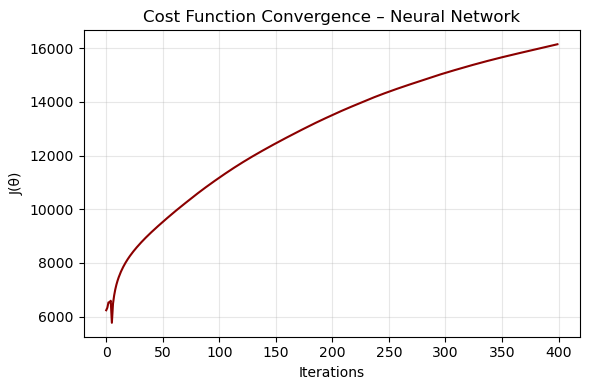

In [17]:
alpha = 0.5
iterations = 400
Lambda = 0.1

Theta1, Theta2, J_history = gradient_descent_nn(
    X_train_scaled, y_train, input_layer_size, hidden_layer_size, output_layer_size, alpha, iterations, Lambda
)

# Plot cost curve
plt.figure(figsize=(6,4))
plt.plot(J_history, color='darkred')
plt.title("Cost Function Convergence – Neural Network")
plt.xlabel("Iterations")
plt.ylabel("J(θ)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 📈 Predictions and Evaluation

In [18]:
def predict_nn(Theta1, Theta2, X):
    """Forward pass to generate predictions"""
    X = np.c_[np.ones((X.shape[0], 1)), X]
    a2 = sigmoid(X @ Theta1.T)
    a2 = np.c_[np.ones((a2.shape[0], 1)), a2]
    a3 = sigmoid(a2 @ Theta2.T)
    return (a3 >= 0.5).astype(int)

y_pred = predict_nn(Theta1, Theta2, X_test_scaled)

# Evaluation metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"✅ Accuracy:  {acc:.4f}")
print(f"✅ Precision: {prec:.4f}")
print(f"✅ Recall:    {rec:.4f}")
print(f"✅ F1-score:  {f1:.4f}")


✅ Accuracy:  0.9917
✅ Precision: 0.9989
✅ Recall:    0.9900
✅ F1-score:  0.9944


# 📊 Confusion Matrix and Error Analysis

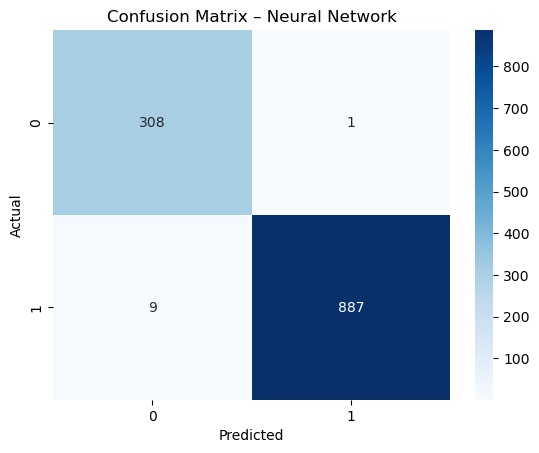

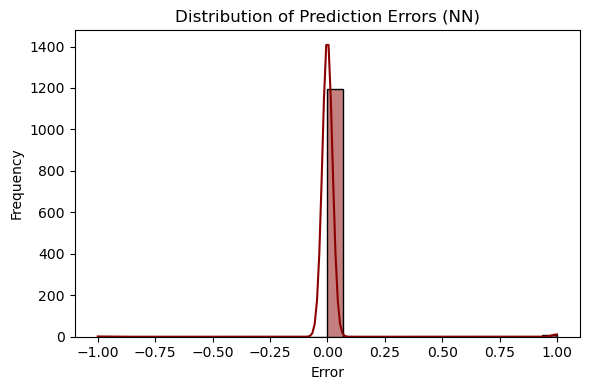

In [19]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Neural Network")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Error distribution
errors = y_test - y_pred.flatten()
plt.figure(figsize=(6,4))
sns.histplot(errors, bins=30, kde=True, color='darkred')
plt.title("Distribution of Prediction Errors (NN)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 📋 Model Summary

In [20]:
print(f"""
🧠 Neural Network Summary
--------------------------
Train Samples: {X_train.shape[0]}
Test Samples:  {X_test.shape[0]}
Features:      {X_train.shape[1]}
Hidden Units:  {hidden_layer_size}

Accuracy:  {acc:.4f}
Precision: {prec:.4f}
Recall:    {rec:.4f}
F1-score:  {f1:.4f}
""")


🧠 Neural Network Summary
--------------------------
Train Samples: 5521
Test Samples:  1205
Features:      16384
Hidden Units:  64

Accuracy:  0.9917
Precision: 0.9989
Recall:    0.9900
F1-score:  0.9944



# 💾 Save results for comparison

In [21]:
results = {
    "Model": "Neural Network",
    "Accuracy": round(acc, 4),
    "Precision": round(prec, 4),
    "Recall": round(rec, 4),
    "F1": round(f1, 4)
}

with open("results_neural_network.json", "w") as f:
    json.dump(results, f, indent=4)

print("✅ Saved Neural Network results to 'results_neural_network.json'")

✅ Saved Neural Network results to 'results_neural_network.json'
